# Paper Information
    Name: Generative Well-intentioned Networks 
    Link: https://papers.nips.cc/paper/9467-generative-well-intentioned-networks.pdf
    
# Authors of Code
    Yasin Berk Gültekin - 1942119 - "e194211@metu.edu.tr"
    Hasan Ali Duran - 1941996 - "e194199@metu.edu.tr"

# Paper Summary

Paper proposes a new framework in order to increase the classifier’s accuracy rate. It uses conditional GAN to understand the distribution of the data which classifier labels with high certainty. It adds an rejection option to classifier since making a prediction about a uncertain input would decrease the accuracy. These rejected inputs translated by the GAN to high-certainty inputs and then relabeled by the classifier.
They combined different loss functions in the paper:
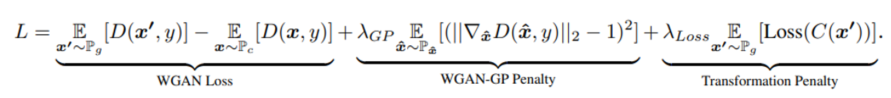
 
Paper uses Wasserstein GAN with gradient penalty and adds Transformation Penalty. Transformation Penalty is a new loss function with a transformation penalty that encourages the conditional generator to produce images that the classifier will label correctly. This penalty is the loss of the classifier when labeling the transformed observations in the current training batch
The WGAN-GP critic is typically trained on both generated data and real data. However, they want the GWIN to generate images from the classifier’s confident distribution. Thus, they prefilter the training data to create a confident distribution Pc containing all images that the classifier labels correctly with high certainty. The critic is then trained exclusively on samples drawn from Pc and generated images by the generator.
Paper uses two different datasets; the MNIST handwritten digits dataset and the Fashion-MNIST clothing dataset.

# Implementation Steps

First of all, we had to calculate a classification precision score for mnist data. For this reason, we had to first implement a classifier. We have implemented our Bayesian Neural Network classifier. Then we train the classifier using all the mnist data. Afterwards, our classifier has calculated the score for each data separately. We used these scores in order to create a subset of our data. And we called this subset critic dataset, we structured this critic data to consist only of those with very high classification scores.
Then we wanted to recreate the data whose classification scores are below a certain threshold, through our generative model. To achieve this, we first implemented a vanillia gan. Later, we updated the discrimator to add contidition to vanillia gan and updated the images to use class label information as input. Then we updated Generator to receive an image as input because we wanted to produce the given image in a better quality. Later, we updated our GAN model by adding the loss functions mentioned in the paper. First of all, we made Wasserstein GAN. We then added a gradient penalty to develop the discriminator. Finally, we calculated the transformation loss and thus, we enabled our Generator to improve for the images we have generated. The model we have has turned into a conditionally customized version of Wasserstein Gan with Gradient Penalty. We then trained only the discriminator using the critic data, but the generator was trained using all the data.
After the entire train process was over, we sent and recreated the data that the classifier did not give enough confidence score to our model. We then calculated the score using the classifier again for the re-created images and also classified them. Then, we compared the original results using the classification results of the new score values and the recreated images. Then, we presented these results to users for comparison.
    
    
# Workflow of Code

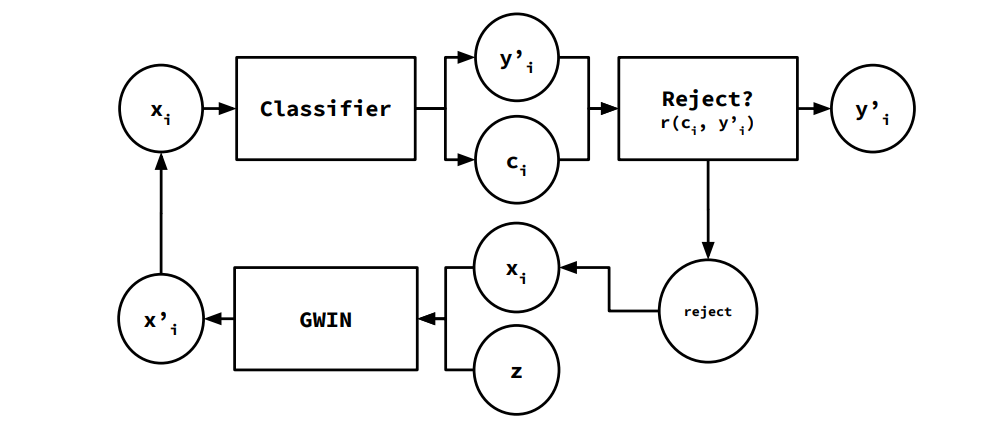

Our system first checks to see if we have a train model. If there is a model that has already been trained, it will load or load these models separately as Classifier and GAN models. If the train operation is to be performed again, it creates the critic dataset because the discriminator in Gan model becomes the train using this data. It also saves the related models after the train operation is finished.
When an image comes next, this image is first examined in the classifier model and an attempt is made to estimate a class label, as well as a confidence score is calculated. If this score is below a certain threshold, the classifier rejects this image and the rejected image is sent to the GAN model. The GAN model uses a rejected image to produce a new image to preserve the image features. This expects the produced image to have a higher confidence score and to be correctly classified.
Then, the re-created image is sent to the classifier and expected to classify again. Classifier's last results are compared with the first results and accordingly, it is calculated how our model offers an overall improvement.

# Challenges Encountered When Implementing Paper

• There was not enough detail about how BNN was implemented. The number of layers was not specified. We could not fully obtain the BNN results mentioned in Paper. The BNN we have implemented makes predictions with higher scores. This situation caused difficulties in the exact occurrence of qualitative results.
• The biggest problem we encountered during GAN implementation was that it was not clear enough how the Generator and Discriminator inputs should be processed in the model. It was not specified how many layers or what types of layers were used. In addition, the pictures produced by the generator appeared similar to those given as input to the Generator. There was no explanation for how this problem was solved in paper implementation. The new method which is transformation loss used during the Discriminator's loss calculation was not sufficiently explained.
You can find our assumptions for the models(like number of layers and type of layers) in the implementation.



In [1]:
!pip install -v pyro-ppl

from torchvision import transforms
from torchvision import datasets
import os.path
import os
import numpy as np
from torchvision.utils import save_image
from torch.autograd import Variable
import torch.nn as nn
import torch.autograd as autograd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import subprocess
import pyro.distributions as dist
import pyro
from matplotlib import colors
from pyro import optim
from pyro.infer import SVI, Trace_ELBO

import Datasets
import Utils
from Parameters import hyper_parameters as parameters

Non-user install because site-packages writeable
Created temporary directory: C:\Users\Lenovo\AppData\Local\Temp\pip-ephem-wheel-cache-0hydjnja
Created temporary directory: C:\Users\Lenovo\AppData\Local\Temp\pip-req-tracker-42gqps1_
Initialized build tracking at C:\Users\Lenovo\AppData\Local\Temp\pip-req-tracker-42gqps1_
Created build tracker: C:\Users\Lenovo\AppData\Local\Temp\pip-req-tracker-42gqps1_
Entered build tracker: C:\Users\Lenovo\AppData\Local\Temp\pip-req-tracker-42gqps1_
Created temporary directory: C:\Users\Lenovo\AppData\Local\Temp\pip-install-2brb3uyx
Cleaning up...
Removed build tracker: 'C:\\Users\\Lenovo\\AppData\\Local\\Temp\\pip-req-tracker-42gqps1_'


### HyperParameters 

    "threshold": [0.7, 0.8, 0.9],
    "critic_threshold": 0.95,
    "n_critic": 5,
    "n_epochs_Classifier": 30,
    "n_epochs_GAN": 200000,
    "batch_size": 128,
    "lr_Classifier": 0.001,
    "lr_GAN": 0.0001,
    "b1": 0.5,
    "b2": 0.9,
    "latent_dim": 100,
    "n_classes": 10,
    "img_size": 28,
    "channels": 1,
    "lambda_gp": 10,
    "lambda_loss": 10,
    "continue_on_existing_training": 0,
    "run_download_sh": 0
    
    These hyperparameters are set in the Parameters.py file.

In [2]:
cuda = True
device = 'cuda' if cuda else 'cpu'
Utils.set_device(cuda)

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

img_shape = (parameters["channels"], parameters["img_size"], parameters["img_size"])

# ---------------------
#  Running Download Script
# ---------------------
if parameters["run_download_sh"]:
    subprocess.call("download.sh", shell=True)


# Models

In [3]:
# ---------------------
#  BNN - Classifier Model
# ---------------------
class BNN(nn.Module):
    def __init__(self):
        super(BNN, self).__init__()

        self.out = nn.Sequential(
            nn.Linear(parameters["img_size"] ** 2, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 10)
        )

    def forward(self, x):
        x = x.flatten(1)
        return self.out(x)


# ---------------------
#  Generator Class
# ---------------------
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.fc = nn.Linear(parameters["latent_dim"], parameters["channels"] * parameters["img_size"] ** 2)

        self.l1 = nn.Sequential(nn.Conv2d(parameters["channels"] * 2, 64, 3, 1, 1), nn.ReLU(inplace=True))

        self.conv_blocks_for_image = nn.Sequential(
            nn.Conv2d(1, 1, 3, stride=2, padding=1),
            nn.Dropout2d(0.1),
            nn.BatchNorm2d(1, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.conv_blocks = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.5),
            nn.Conv2d(256, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.5),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.5),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 16, 3, 1, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),
            nn.BatchNorm2d(16, 0.8),
            nn.Conv2d(16, 1, 3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Tanh(),
        )

        self.l2 = nn.Sequential(
            nn.Linear(4 * parameters["img_size"] ** 2, parameters["channels"] * parameters["img_size"] ** 2),
            nn.Tanh(),
        )

    def forward(self, z, img):
        # img = play_with_image(img)
        first_z = self.fc(z).view(
            [parameters["batch_size"], 1, int(parameters["img_size"]), int(parameters["img_size"])])
        gen_input = torch.cat((img, first_z), 1)
        out = self.l1(gen_input)
        generated_img = self.conv_blocks(out)
        return generated_img


# ---------------------
#  Discriminator Class
# ---------------------
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)) + parameters["n_classes"], 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img, labels):
        gen_input = torch.cat(
            (img.view(parameters["img_size"] * parameters["img_size"], parameters["batch_size"]),
             labels.view(parameters["n_classes"], parameters["batch_size"])), 0). \
            view(parameters["batch_size"], parameters["img_size"] * parameters["img_size"] + parameters["n_classes"])
        validity = self.model(gen_input)
        return validity
    
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()

generator_optimizer = torch.optim.Adam(generator.parameters(), lr=parameters["lr_GAN"],
                                       betas=(parameters["b1"], parameters["b2"]))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=parameters["lr_GAN"],
                                           betas=(parameters["b1"], parameters["b2"]))

# Classifier Model (Bayesian Neural Network)

In [4]:
model = BNN()
if cuda:
    model.cuda()


# ---------------------
#  Stochastic Variational Inference's Module
# ---------------------
def module(x, y):
    priors = {}
    for iterator in model.named_parameters():
        name, param = iterator
        zeros = torch.zeros_like(param.data)
        ones = torch.ones_like(param.data)
        priors[name] = dist.Normal(loc=zeros,
                                   scale=ones)

    lifted_module = pyro.random_module("module", model, priors)
    lifted_module_method = lifted_module()
    lhat = F.log_softmax(lifted_module_method(x), 1)
    pyro.sample("obs", dist.Categorical(logits=lhat), obs=y)


# ---------------------
#  Stochastic Variational Inference's Guide
# ---------------------
def guide(x, y):
    priors = {}
    for iterator in model.named_parameters():
        name, param = iterator
        priors[name] = dist.Normal(loc=pyro.param(name + '.mu', torch.randn_like(param)),
                                   scale=F.softplus(pyro.param(name + '.sigma', torch.randn_like(param))))

    lifted_module = pyro.random_module('module', model, priors)
    return lifted_module()

opt = optim.Adam({'lr': parameters["lr_Classifier"]})
svi = SVI(module, guide, opt, loss=Trace_ELBO())

# ---------------------
#  Classifier's prediction method
# ---------------------
def predict(x, y):
    sampled_models = [guide(None, None) for _ in range(parameters["n_classes"])]
    yhats = [model(x.to(device)).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    predsProbs, preds = torch.max(F.softmax(mean).to(device), 1)
    return predsProbs, preds


# Creating Masked Dataset

In [5]:
mask = []

# ---------------------
#  Creates Mask To Train Discriminator With P_Critic
# ---------------------
def create_critic_mask():
    print("Creating mask to train model with only critic dataset...")
    for i in range(int(len(Datasets.trainset) / parameters["batch_size"])):
        # obtain one batch of training images
        dataiter = iter(Datasets.trainloader)
        images, labels = dataiter.next()
        images, labels = Utils.arrange_data_tensors(images, labels)

        predsProbs, preds= predict(images, labels)
        # convert output probabilities to predicted class
        # predsProbs, preds = torch.max(output, 1)
        for j in range(parameters["batch_size"]):
            mask.append(1 if predsProbs[j].item() > parameters["critic_threshold"] else 0)


create_critic_mask()
mask = FloatTensor(mask)


# ---------------------
#  Sampler Class to use mask
# ---------------------
class SpecialSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, mask, data_source):
        self.mask = mask
        self.data_source = data_source

    def __iter__(self):
        return iter([i.item() for i in torch.nonzero(mask)])

    def __len__(self):
        return len(self.data_source)

Creating mask to train model with only critic dataset...


C:\Users\Lenovo\anaconda3\lib\site-packages\pyro\primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)
C:\Users\Lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


## Training And Saving Models

In [6]:
# ---------------------
#  Trains Classifier Model
# ---------------------

def train_classifier_model():
    pyro.clear_param_store()

    total_loss = 0
    for epoch in range(parameters["n_epochs_Classifier"]):
        loss = 0
        for x, y in Datasets.trainloader:
            loss += svi.step(x.flatten(1).to(device), y.to(device))
        total_loss = loss / len(Datasets.trainloader.dataset)
        print("Epoch: %d Loss: %f" % (epoch + 1, total_loss))

    pyro.get_param_store().save('paramstore.out')
    torch.save(model.state_dict(), 'ClassifierModel.pt')

# ---------------------
#  Trains Generative Adverserial Network model
# ---------------------
def train_GAN():
    sampler = SpecialSampler(mask, Datasets.trainset)
    criticLoader = torch.utils.data.DataLoader(
        Datasets.trainset,
        drop_last=True,
        batch_size=parameters["batch_size"],
        sampler=sampler,
        shuffle=False
    )
    batches_done = 0
    for epoch in range(parameters["n_epochs_GAN"]):
        for i, (imgs, labels) in enumerate(criticLoader):
            hot_labels = Utils.create_one_hot_label(labels)

            real_images = Variable(imgs.type(FloatTensor))
            labels = Variable(labels.type(LongTensor))

            discriminator_optimizer.zero_grad()

            z = Variable(FloatTensor(np.random.normal(0, 1, (parameters["batch_size"], parameters["latent_dim"]))))

            generated_images = generator(z, real_images)

            d_loss = Utils.calculate_discriminator_loss(discriminator, real_images, generated_images, hot_labels)

            d_loss.backward()
            discriminator_optimizer.step()

            generator_optimizer.zero_grad()

            if i % parameters["n_critic"] == 0:
                dataiter = iter(Datasets.trainloader)
                pr_images, pr_labels = dataiter.next()

                pr_images = Variable(pr_images.type(FloatTensor))
                pr_labels = Variable(pr_labels.type(LongTensor))

                generated_images = generator(z, pr_images)
                pr_hot_labels = Utils.create_one_hot_label(pr_labels)

                fake_validity = discriminator(generated_images, pr_hot_labels)
                # Calculating transformation penalty
                transformation_loss = Utils.calculate_transformation_loss(generated_images, svi, pr_labels)

                g_loss = -torch.mean(fake_validity) + (parameters["lambda_loss"] * transformation_loss)

                g_loss.backward()
                generator_optimizer.step()

                Utils.print_batch_progress(i, d_loss, g_loss)
                if batches_done % 100 == 0:
                    save_image(generated_images.data[:25], "images/wgan/%d.png" % batches_done, nrow=5, normalize=True)

                batches_done += batches_done + parameters["n_critic"]

        Utils.print_epoch_progress(epoch + 1, d_loss, g_loss)

    save_GAN_models()
    
# ---------------------
#  Saves Generator and Discriminator Models
# ---------------------
def save_GAN_models():
    torch.save(generator.state_dict(), 'GeneratorModel.pt')
    torch.save(discriminator.state_dict(), 'DiscriminatorModel.pt')
   
    
train_classifier_model()
train_GAN()

Epoch: 1 Loss: 11303.319796


In [8]:
# ---------------------
#  Test for Classifier
# ---------------------
def test_classifier():
    correct = 0
    total = 0
    for x, y in Datasets.testloader:
        x, y = Utils.arrange_data_tensors(x, y)
        predsProbs, preds = predict(x.flatten(1), y)
        total += parameters["batch_size"]
        correct += (preds == y).sum().item()
    print("Accuracy: %f" % (correct / total))

test_classifier()

C:\Users\Lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 0.832833


In [31]:
# ---------------------
#  Loads Generator and Discriminator Models
# ---------------------
def load_GAN_models():
    generator.load_state_dict(torch.load('GeneratorModel.pt' ,map_location=device))
    discriminator.load_state_dict(torch.load('DiscriminatorModel.pt', map_location=device))
    
# ---------------------
#  Trains or loads classifier model
# ---------------------
def create_classifier_model():
    if (not os.path.exists('ClassifierModel.pt') or not os.path.exists('paramstore.out')):
        train_classifier_model()
        test_classifier()
    else:
        pyro.get_param_store().load('paramstore.out', map_location=device)
        model.load_state_dict(torch.load('ClassifierModel.pt', map_location=device))

# ---------------------
#  Loads Models Or Trains Classifier, Generator, Discriminator Models
# ---------------------
def load_or_train_models():
    create_classifier_model()

    if parameters["continue_on_existing_training"] or (
            not (os.path.exists('DiscriminatorModel.pt') or os.path.exists('GeneratorModel.pt'))):
        
        if parameters["continue_on_existing_training"] == True and (
                os.path.exists('DiscriminatorModel.pt') and os.path.exists('GeneratorModel.pt')):
            load_GAN_models()

        train_GAN()
    else:
        load_GAN_models()



## Loading Models And Printing Results

test_models produces quantitive and qualitive results.

1)Quantitive result is generating a handwritten number which has a certainty that is under threshold.(Figure 2 from Paper)

2)Qualitive result is printing three rows of the "Table 1" from the paper.
It produces results for [0.7, 0.8, 0.9] thresholds (Three rows of the Table 1)

Generating images and printing results...
-------------------Results for Threshold: 0.700000 -------------------


C:\Users\Lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


----------Qualitative Results for Threshold----------
Original Image : 0.535068 (Prediction Acc) || Old Label:  6


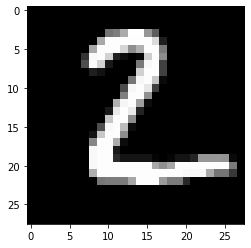

Generated Image: 1.000000 (Prediction Acc) || New Label:  2


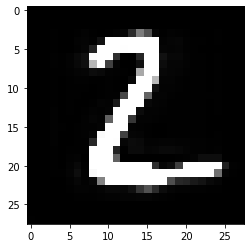

----------Qualitative Results for Threshold----------

----------Quantitative Results for Threshold----------
Reject            : 0.063000
BNN Accuracy      : 39.682540
BNN+GWIN Accuracy : 55.555556
Rejected Accuracy : 15
Overall Accuracy  : 0.010000
Error             : -25.195263
----------Quantitative Results for Threshold----------
-------------------Results for Threshold: 0.700000 -------------------


-------------------Results for Threshold: 0.800000 -------------------
----------Qualitative Results for Threshold----------
Original Image : 0.593668 (Prediction Acc) || Old Label:  5


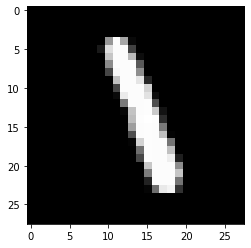

Generated Image: 1.000000 (Prediction Acc) || New Label:  1


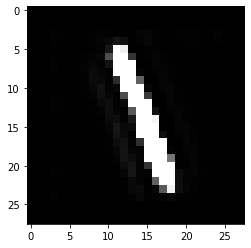

----------Qualitative Results for Threshold----------

----------Quantitative Results for Threshold----------
Reject            : 0.101000
BNN Accuracy      : 42.574257
BNN+GWIN Accuracy : 65.346535
Rejected Accuracy : 22
Overall Accuracy  : 0.023000
Error             : -22.546809
----------Quantitative Results for Threshold----------
-------------------Results for Threshold: 0.800000 -------------------


-------------------Results for Threshold: 0.900000 -------------------
----------Qualitative Results for Threshold----------
Original Image : 0.808852 (Prediction Acc) || Old Label:  7


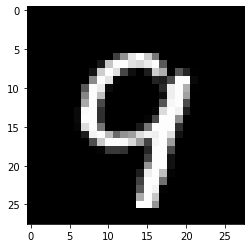

Generated Image: 1.000000 (Prediction Acc) || New Label:  9


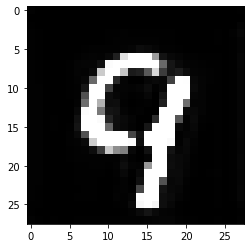

----------Qualitative Results for Threshold----------

----------Quantitative Results for Threshold----------
Reject            : 0.159000
BNN Accuracy      : 35.849057
BNN+GWIN Accuracy : 64.779874
Rejected Accuracy : 28
Overall Accuracy  : 0.046000
Error             : -18.195483
----------Quantitative Results for Threshold----------
-------------------Results for Threshold: 0.900000 -------------------




In [30]:
# ---------------------
#  Test
# ---------------------
def test_models():
    load_or_train_models()
    print("Generating images and printing results...")
    for threshold_index in range(len(parameters["threshold"])):
        print('-------------------Results for Threshold: %2f -------------------' % parameters["threshold"][threshold_index])
        counter = 0
        probUnderThreshold = 0
        probUnderThresholdButCorrectClassified = 0
        probUnderThresholdThenClassifiedCorrectClassified = 0
        probAboveThresholdAndCorrectClassified = 0
        probAboveThresholdAlsoClassifiedCorrectClassified = 0

        for i in range(10):
            for j in range(int(len(Datasets.testset) / parameters["batch_size"])):
                # obtain one batch of training images
                dataiter = iter(Datasets.testloader)
                images, labels = dataiter.next()

                images, labels = Utils.arrange_data_tensors(images, labels)

                predsProbs, preds = predict(images, labels)

                for k in range(parameters["batch_size"]):

                    idx = (i * int(len(Datasets.testset))) + (j * parameters["batch_size"]) + k

                    trueLabel = labels[k].item()
                    modelsPrediction = preds[k].item()
                    modelsPredictionProb = predsProbs[k].item()

                    if (modelsPredictionProb < parameters["threshold"][threshold_index]):
                        probUnderThreshold = probUnderThreshold + 1
                        if (trueLabel == modelsPrediction):
                            probUnderThresholdButCorrectClassified = probUnderThresholdButCorrectClassified + 1
                    else:
                        if (trueLabel == modelsPrediction):
                            probAboveThresholdAndCorrectClassified = probAboveThresholdAndCorrectClassified + 1

                    if (predsProbs[k] < parameters["threshold"][threshold_index]):
                        #save_image(images[k], "images/result_images/%d" % idx + "_original_image.png", nrow=1,normalize=True)

                        generatedImage = Utils.sample_single_image(images, k, generator,
                                                             "images/result_images/%d" % idx + "_generated_image_.png",
                                                             True)
                        lastPredsProbs, lastPreds = predict(generatedImage.view(1, 1, 28, 28), labels)

                        if not modelsPrediction == trueLabel and lastPreds.item() == trueLabel and counter < 1:
                            print('----------Qualitative Results for Threshold----------')
                            print('Original Image : %2f (Prediction Acc) || Old Label: %2d' % (predsProbs[k], preds[k]))
                            Utils.show_image(images[k])
                            print("Generated Image: %2f (Prediction Acc) || New Label: %2d" % (lastPredsProbs.item(), lastPreds.item()))
                            Utils.show_image(generatedImage)
                            counter = counter + 1
                            print('----------Qualitative Results for Threshold----------\n')

                        if (lastPreds.item() == trueLabel):
                            probUnderThresholdThenClassifiedCorrectClassified = probUnderThresholdThenClassifiedCorrectClassified + 1

        total_images = 100000.0

        reject = (float(100 * probUnderThreshold) / total_images)
        bnnAcc = (100 * probUnderThresholdButCorrectClassified / probUnderThreshold)
        bnn_and_gwinAcc = (100 * probUnderThresholdThenClassifiedCorrectClassified / probUnderThreshold)
        overallAcc = (float(100 * (
                probUnderThresholdThenClassifiedCorrectClassified - probUnderThresholdButCorrectClassified)) / total_images)
        error = (100 * (bnnAcc - bnn_and_gwinAcc)) / probUnderThreshold

        print('----------Quantitative Results for Threshold----------')
        print('Reject            : %2f' % reject)
        print('BNN Accuracy      : %2f' % bnnAcc)
        print('BNN+GWIN Accuracy : %2f' % bnn_and_gwinAcc)
        print('Rejected Accuracy : %2d' % (bnn_and_gwinAcc - bnnAcc))
        print('Overall Accuracy  : %2f' % overallAcc)
        print('Error             : %2f' % error)
        print('----------Quantitative Results for Threshold----------')

        print('-------------------Results for Threshold: %2f -------------------\n\n' % parameters["threshold"][threshold_index])

        
test_models()
